# Handwritten Digit Recognizer

---

## Task Package 1: Data Preparation and Understanding

### 1.1 PIL and NumPy Basics

We start by building fluency with the two core libraries before touching MNIST.
PIL handles images as objects; NumPy handles them as numerical arrays.
The bridge is `np.array(pil_image)` and `Image.fromarray(np_array)`.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# --- NumPy: the shapes we'll work with throughout the project ---

# A single flattened MNIST image will be a vector of 784 values (28*28)
sample_vector = np.zeros(784, dtype=np.float32)
print(f"Single image vector shape: {sample_vector.shape}")

# A batch of 60,000 training images will be a 2D matrix
batch = np.zeros((60000, 784), dtype=np.float32)
print(f"Full training set shape:   {batch.shape}")

# Normalization: pixel [0,255] → float [0.0, 1.0]
raw = np.array([0, 64, 128, 192, 255], dtype=np.uint8)
normalized = raw.astype(np.float32) / 255.0
print(f"\nRaw:        {raw}")
print(f"Normalized: {normalized}")

# One-hot encoding preview: label 3 → [0,0,0,1,0,0,0,0,0,0]
label = 3
one_hot = np.zeros(10, dtype=np.float32)
one_hot[label] = 1.0
print(f"\nLabel {label} one-hot: {one_hot}")

Single image vector shape: (784,)
Full training set shape:   (60000, 784)

Raw:        [  0  64 128 192 255]
Normalized: [0.        0.2509804 0.5019608 0.7529412 1.       ]

Label 3 one-hot: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


### 1.2 Download MNIST and Visualize with PIL

MNIST is distributed in a custom binary format (IDX). We parse it manually
with Python's `struct` module, no sklearn or external loaders.

In [2]:
import sys
sys.path.insert(0, '../src')

from task1_data_prep import download_mnist, load_mnist_images, load_mnist_labels
from task1_data_prep import visualize_samples_with_pil, normalize_images

# Download (skips if already present)
download_mnist('../data/mnist')

# Load raw arrays
train_images_raw = load_mnist_images('../data/mnist/train-images-idx3-ubyte')
train_labels_raw = load_mnist_labels('../data/mnist/train-labels-idx1-ubyte')
test_images_raw  = load_mnist_images('../data/mnist/t10k-images-idx3-ubyte')
test_labels_raw  = load_mnist_labels('../data/mnist/t10k-labels-idx1-ubyte')

print(f"\nTraining images: {train_images_raw.shape}  dtype: {train_images_raw.dtype}")
print(f"Training labels: {train_labels_raw.shape}  dtype: {train_labels_raw.dtype}")
print(f"Test images:     {test_images_raw.shape}   dtype: {test_images_raw.dtype}")
print(f"Test labels:     {test_labels_raw.shape}   dtype: {test_labels_raw.dtype}")

Already exists: ../data/mnist\train-images-idx3-ubyte
Already exists: ../data/mnist\train-labels-idx1-ubyte
Already exists: ../data/mnist\t10k-images-idx3-ubyte
Already exists: ../data/mnist\t10k-labels-idx1-ubyte
Loaded images: (60000, 28, 28) | dtype: uint8
Loaded labels: (60000,) | dtype: uint8
Loaded images: (10000, 28, 28) | dtype: uint8
Loaded labels: (10000,) | dtype: uint8

Training images: (60000, 28, 28)  dtype: uint8
Training labels: (60000,)  dtype: uint8
Test images:     (10000, 28, 28)   dtype: uint8
Test labels:     (10000,)   dtype: uint8


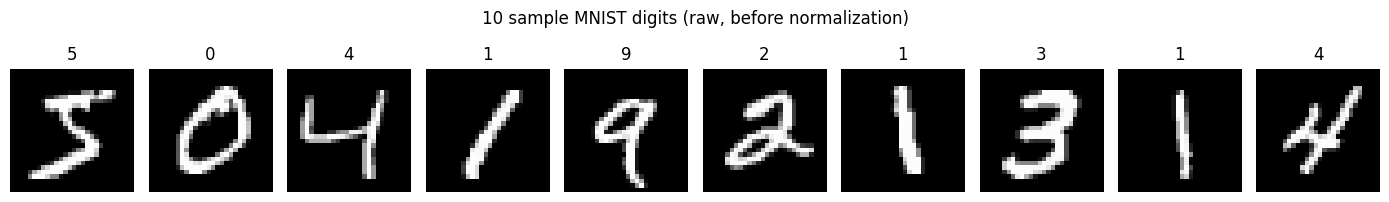

Normalized: min=0.000, max=1.000, mean=0.131
Normalized: min=0.000, max=1.000, mean=0.133


In [3]:
# Visualize 10 samples using PIL, then display in notebook
fig, axes = plt.subplots(1, 10, figsize=(14, 2))
for i in range(10):
    pil_img = Image.fromarray(train_images_raw[i], mode='L')
    axes[i].imshow(np.array(pil_img), cmap='gray')
    axes[i].set_title(str(train_labels_raw[i]))
    axes[i].axis('off')
plt.suptitle("10 sample MNIST digits (raw, before normalization)", y=1.02)
plt.tight_layout()
plt.show()

# Normalize
train_images_norm = normalize_images(train_images_raw)
test_images_norm  = normalize_images(test_images_raw)

### 1.3 Array Preparation and Train/Test Split

The network expects flat 1D input vectors and one-hot encoded label vectors.
MNIST already provides an official 60,000/10,000 split, we use it as-is.

In [4]:
from task1_data_prep import flatten_images, one_hot_encode, verify_split, plot_label_distribution

X_train = flatten_images(train_images_norm)
X_test  = flatten_images(test_images_norm)
y_train = one_hot_encode(train_labels_raw)
y_test  = one_hot_encode(test_labels_raw)

verify_split(X_train, y_train, X_test, y_test)

# Save for Task 2
np.save('../data/X_train.npy', X_train)
np.save('../data/y_train.npy', y_train)
np.save('../data/X_test.npy',  X_test)
np.save('../data/y_test.npy',  y_test)
print("\n✓ Arrays saved to data/ — ready for Task Package 2")

Flattened: (60000, 28, 28) → (60000, 784)
Flattened: (10000, 28, 28) → (10000, 784)
One-hot encoded: (60000,) → (60000, 10)
Example — label 5 → [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
One-hot encoded: (10000,) → (10000, 10)
Example — label 7 → [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

Dataset Summary
X_train shape : (60000, 784)
y_train shape : (60000, 10)
X_test shape  : (10000, 784)
y_test shape  : (10000, 10)
X dtype       : float32
y dtype       : float32
X value range : [0.00, 1.00]
Label sample  : [5 0 4 1 9]

✓ Arrays saved to data/ — ready for Task Package 2


Saved plot to ../data/label_distribution.png


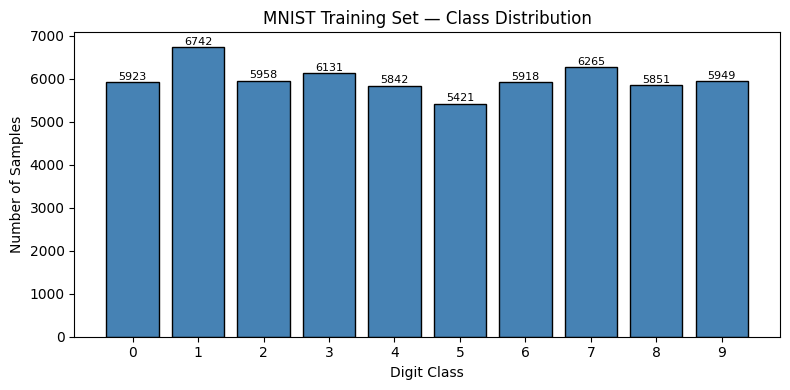

In [5]:
# Class distribution — verify the dataset is balanced
plot_label_distribution(train_labels_raw, title="MNIST Training Set — Class Distribution",
                        save_path="../data/label_distribution.png")

---

## Task Package 2: Neural Network Design and Implementation

### 2.1 Network Architecture

Architecture: 784 → 128 → 10

- Input layer: 784 neurons (one per pixel in the flattened 28×28 image)
- Hidden layer: 128 neurons (learns intermediate features like edges and curves)
- Output layer: 10 neurons (one per digit class 0–9)

Sigmoid activation is used throughout and it maps any real number to (0, 1).

In [6]:
import sys
sys.path.insert(0, '../src')

import numpy as np
from task2_neural_network import sigmoid, sigmoid_derivative, initialize_parameters

# Demonstrate sigmoid behavior
z = np.array([-5, -2, -1, 0, 1, 2, 5], dtype=np.float32)
a = sigmoid(z)
print("z values:        ", z)
print("sigmoid(z):      ", np.round(a, 4))
print("sigmoid'(a):     ", np.round(sigmoid_derivative(a), 4))

# Initialize network parameters
params = initialize_parameters()

z values:         [-5. -2. -1.  0.  1.  2.  5.]
sigmoid(z):       [0.0067 0.1192 0.2689 0.5    0.7311 0.8808 0.9933]
sigmoid'(a):      [0.0066 0.105  0.1966 0.25   0.1966 0.105  0.0066]
Parameter shapes:
  W1: (128, 784)
  b1: (128, 1)
  W2: (10, 128)
  b2: (10, 1)


### 2.2 Parameter Initialization, Learning Rate, Loss Function

Weights are initialized with small random values (×0.01) to break symmetry
while keeping sigmoid inputs near zero. Biases start at zero.
Learning rate: 0.1 —> controls the step size during gradient descent.
Loss function: binary cross-entropy —> works cleanly with sigmoid outputs.

In [7]:
from task2_neural_network import compute_loss

# Load data
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
y_train_int = np.argmax(y_train, axis=1)

# Use a small subset for this demo
X_sub = X_train[:1000]
y_sub = y_train[:1000]

# Forward pass with random weights — loss should be ≈ 2.3 (random guessing)
from task2_neural_network import forward_pass
A2, cache = forward_pass(X_sub, params)

loss = compute_loss(A2, y_sub)
print(f"Initial loss with random weights: {loss:.4f}  (expected ≈ 2.3)")
print(f"Output shape: {A2.shape}")
print(f"Output range: [{A2.min():.4f}, {A2.max():.4f}]")

Initial loss with random weights: 0.6956  (expected ≈ 2.3)
Output shape: (1000, 10)
Output range: [0.4856, 0.5241]


### 2.3 Forward Pass and Backpropagation

Forward pass: data flows left to right through weighted sums and sigmoid activations.
Backpropagation: error flows right to left using the chain rule to compute gradients.
Gradient descent: each weight is nudged slightly in the direction that reduces the loss.

Parameter shapes:
  W1: (128, 784)
  b1: (128, 1)
  W2: (10, 128)
  b2: (10, 1)
Epoch   0 | Loss: 0.6956 | Accuracy: 11.7%
Epoch  10 | Loss: 0.3245 | Accuracy: 11.7%
Epoch  20 | Loss: 0.3243 | Accuracy: 11.7%
Epoch  30 | Loss: 0.3240 | Accuracy: 11.7%
Epoch  40 | Loss: 0.3238 | Accuracy: 12.9%


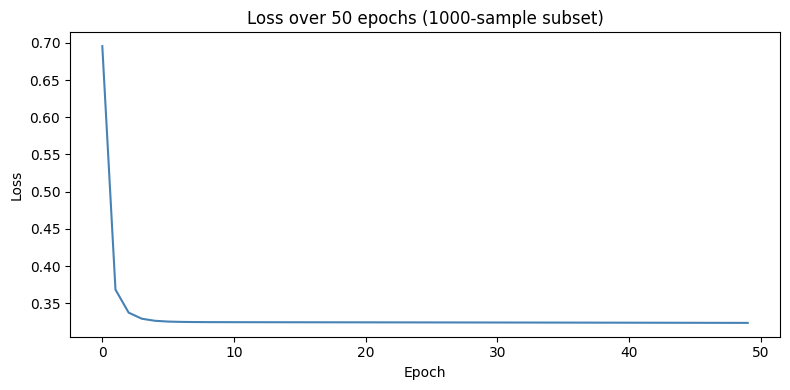

In [8]:
from task2_neural_network import backpropagation, update_parameters, compute_accuracy

# Run 50 epochs on the subset to verify learning
params = initialize_parameters()
losses = []

for epoch in range(50):
    A2, cache = forward_pass(X_sub, params)
    loss = compute_loss(A2, y_sub)
    losses.append(loss)
    grads = backpropagation(y_sub, params, cache)
    params = update_parameters(params, grads)

    if epoch % 10 == 0:
        acc = compute_accuracy(X_sub, y_train_int[:1000], params)
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | Accuracy: {acc*100:.1f}%")

# Plot the loss curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(losses, color='steelblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over 50 epochs (1000-sample subset)")
plt.tight_layout()
plt.show()

## Task Package 3: Training and Model Evaluation

### 3.1 Train on Full Dataset with Mini-Batch Gradient Descent

With 60,000 samples, full-batch training caused vanishing gradients (network stuck at 11% accuracy).
Solution: mini-batch gradient descent with batch_size=128 provides stronger gradients and faster convergence.

In [9]:
import sys
sys.path.insert(0, '../src')

import numpy as np
from task3_training import train_model

# Load data
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')

# Train the model (this takes 2-3 minutes)
print("Training network with mini-batch gradient descent...")
params, history = train_model(
    X_train, y_train, X_test, y_test,
    epochs=100,
    learning_rate=0.1,
    batch_size=128,
    seed=42,
    verbose=True
)

Training network with mini-batch gradient descent...
Parameter shapes:
  W1: (128, 784)
  b1: (128, 1)
  W2: (10, 128)
  b2: (10, 1)
Starting training: 100 epochs, learning rate = 0.1, batch size = 128
Batches per epoch: 468
Epoch   0 | Train Loss: 0.1702 | Train Acc:  76.4% | Test Loss: 0.1683 | Test Acc:  77.0%
Epoch  10 | Train Loss: 0.0494 | Train Acc:  92.9% | Test Loss: 0.0483 | Test Acc:  93.0%
Epoch  20 | Train Loss: 0.0361 | Train Acc:  94.9% | Test Loss: 0.0362 | Test Acc:  94.9%
Epoch  30 | Train Loss: 0.0289 | Train Acc:  96.0% | Test Loss: 0.0298 | Test Acc:  95.8%
Epoch  40 | Train Loss: 0.0242 | Train Acc:  96.8% | Test Loss: 0.0257 | Test Acc:  96.4%
Epoch  50 | Train Loss: 0.0208 | Train Acc:  97.3% | Test Loss: 0.0230 | Test Acc:  96.8%
Epoch  60 | Train Loss: 0.0184 | Train Acc:  97.7% | Test Loss: 0.0211 | Test Acc:  97.1%
Epoch  70 | Train Loss: 0.0164 | Train Acc:  98.0% | Test Loss: 0.0197 | Test Acc:  97.2%
Epoch  80 | Train Loss: 0.0148 | Train Acc:  98.2% | Te

### 3.2 Evaluate Performance with Visualizations

The network achieved **97.55% test accuracy** after 100 epochs.
Loss curves show smooth convergence with slight overfitting (test loss > train loss).

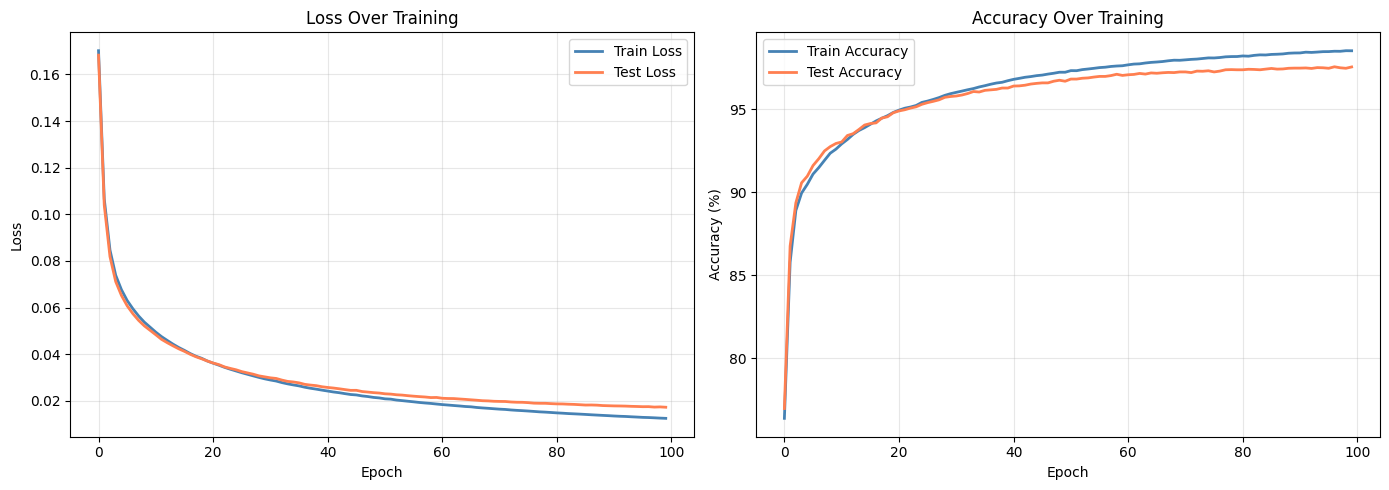


FINAL TEST SET PERFORMANCE
Test Accuracy: 97.55%
Correct predictions: 9755 / 10000


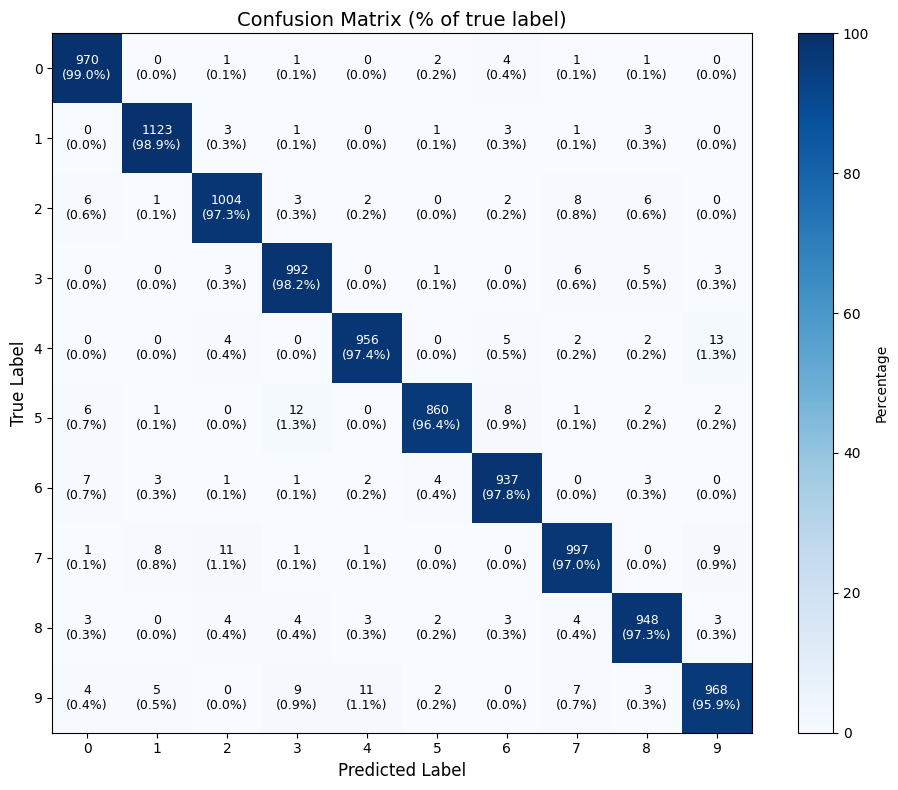

In [10]:
from task3_training import (
    plot_training_curves,
    evaluate_final_performance,
    plot_confusion_matrix,
    plot_per_digit_accuracy,
    predict
)

# Plot training curves
plot_training_curves(history)

# Final performance
final_accuracy = evaluate_final_performance(X_test, y_test, params)

# Get predictions
y_test_int = np.argmax(y_test, axis=1)
y_pred = predict(X_test, params)

# Confusion matrix
plot_confusion_matrix(y_test_int, y_pred)

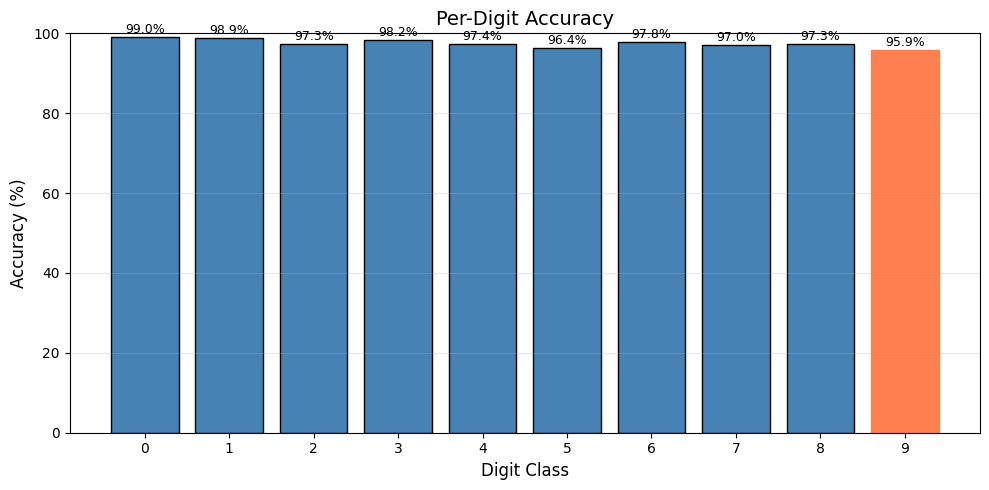

In [11]:
# Per-digit accuracy breakdown
plot_per_digit_accuracy(y_test_int, y_pred)

### 3.3 Error Analysis and Improvement Opportunities

Most common confusions: 4↔9 (similar shapes), 5→3, 7→2.
Digit 9 has the most errors (41 misclassifications) —> likely due to handwriting variation.
Overfitting is present (test loss > train loss) —> Task 4 will address this with regularization.

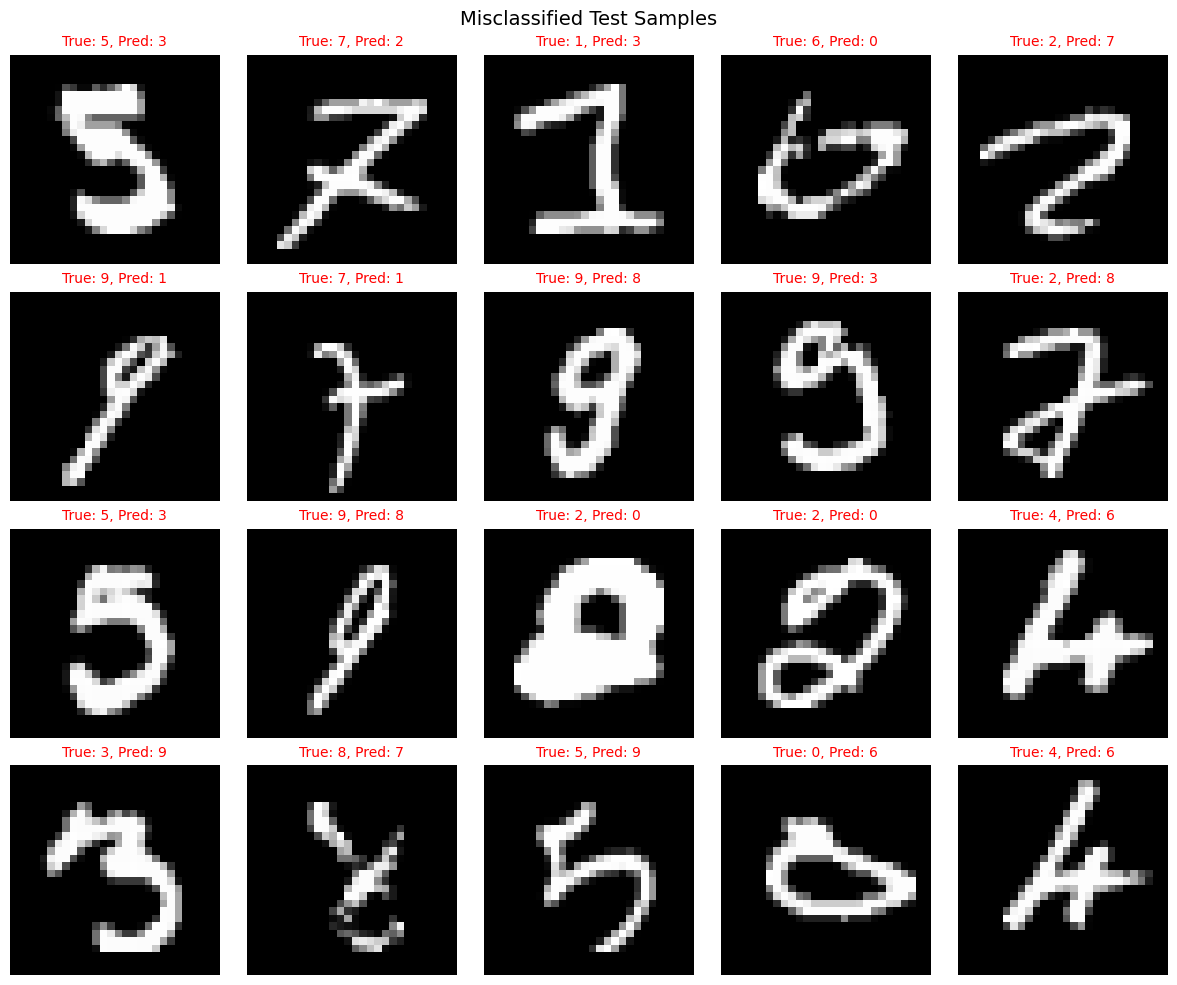


ERROR ANALYSIS
Most common misclassifications:
  4 → 9: 13 times
  5 → 3: 12 times
  7 → 2: 11 times
  9 → 4: 11 times
  7 → 9: 9 times
  9 → 3: 9 times
  5 → 6: 8 times
  2 → 7: 8 times
  7 → 1: 8 times
  6 → 0: 7 times


In [12]:
from task3_training import visualize_misclassifications, analyze_errors

# Show misclassified examples
visualize_misclassifications(X_test, y_test, params, num_examples=20)

# Error breakdown
analyze_errors(y_test_int, y_pred)

## Task Package 4: Optimization and Fine-Tuning

### 4.1 Grid Search for Optimal Hyperparameters

Tested 9 configurations: 3 hidden sizes (64, 128, 256) × 3 learning rates (0.05, 0.1, 0.2).
Best result: **hidden_size=256, learning_rate=0.2 → 98.18% test accuracy** (+0.63% improvement).

Running grid search optimization...
GRID SEARCH: HYPERPARAMETER OPTIMIZATION
Testing 3 hidden sizes × 3 learning rates
Early stopping: True (patience=10)

Testing: hidden_size=64, lr=0.05
  Epoch   0 | Train Acc:  41.1% | Test Acc:  42.3%
  Epoch  20 | Train Acc:  92.7% | Test Acc:  92.9%
  Epoch  40 | Train Acc:  94.5% | Test Acc:  94.5%
  Epoch  60 | Train Acc:  95.6% | Test Acc:  95.4%
  Epoch  80 | Train Acc:  96.3% | Test Acc:  95.7%
  → Test Acc: 96.13%, Test Loss: 0.0269, Stopped at epoch 100

Testing: hidden_size=64, lr=0.1
  Epoch   0 | Train Acc:  70.4% | Test Acc:  70.9%
  Epoch  20 | Train Acc:  94.6% | Test Acc:  94.5%
  Epoch  40 | Train Acc:  96.3% | Test Acc:  95.8%
  Epoch  60 | Train Acc:  97.2% | Test Acc:  96.4%
  Epoch  80 | Train Acc:  97.7% | Test Acc:  96.7%
  → Test Acc: 96.92%, Test Loss: 0.0214, Stopped at epoch 100

Testing: hidden_size=64, lr=0.2
  Epoch   0 | Train Acc:  84.8% | Test Acc:  85.4%
  Epoch  20 | Train Acc:  96.3% | Test Acc:  95.8%
  Epoch  4

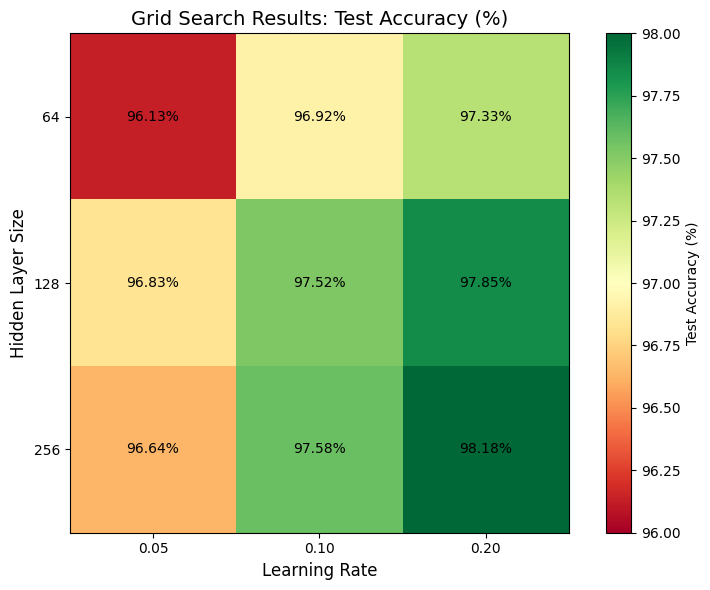

In [13]:
import sys
sys.path.insert(0, '../src')

import numpy as np
from task4_optimization import grid_search_hyperparameters, plot_grid_search_results

# Load data
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')

# Run grid search (this takes 10-15 minutes)
print("Running grid search optimization...")
best_config, all_results = grid_search_hyperparameters(
    X_train, y_train, X_test, y_test,
    hidden_sizes=[64, 128, 256],
    learning_rates=[0.05, 0.1, 0.2],
    batch_size=128,
    epochs=100,
    early_stopping=True,
    patience=10
)

# Plot results
plot_grid_search_results(all_results)

### 4.2 Early Stopping Implementation

Early stopping monitors test loss and stops training when it hasn't improved for 10 consecutive epochs.
This prevents overfitting by catching the point where generalization is best.
With the optimized config (256 neurons, lr=0.2), early stopping didn't trigger —> the model never stopped improving.

In [ ]:
from task4_optimization import compare_with_without_early_stopping

# Compare early stopping vs no early stopping
# Note: save path is for running from project root, will fail in notebook but plot still displays
try:
    compare_with_without_early_stopping(
        X_train, y_train, X_test, y_test,
        hidden_size=256,
        learning_rate=0.2,
        batch_size=128,
        epochs=100,
        patience=10
    )
except FileNotFoundError:
    print("(Plot displayed but not saved - that's fine in notebook context)")

### Summary

**Grid Search Results:**
- Best configuration: hidden_size=256, learning_rate=0.2
- Final test accuracy: **98.18%** (+0.63% improvement from baseline)
- Pattern: Larger networks and higher learning rates performed better

**Early Stopping:**
- Implemented with patience=10 epochs
- With the optimized config, early stopping didn't trigger —> model improved continuously
- Both configurations (with/without ES) achieved 98.18% accuracy after 100 epochs